In [1]:
import uproot4
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
import os
import numpy as np
import pandas as pd
import itertools

from event_display import  build_calorimeter_section

In [2]:
pics_prefix = os.path.join("plots", "v1_")

In [3]:
from data_tools import merge_clusters
from geant3_parser import build_true_answers_train_set
from geant3_parser import Geant3DataFile

def norm_func(e):
    return np.float64(np.log(e) / 11)

file_name = os.path.join('data', 'shower_geant3_new.dat')
data_file = Geant3DataFile(file_name, skip_lines=3)

events_to_read = 5000
inputs, answers, values = build_true_answers_train_set(data_file, events_to_read*2, norm_func=norm_func, rnd_shift=((-2,2), (-2,2)))

print(f"Inputs shape original = {np.shape(inputs)}")
print(f"max hit value = {np.max(inputs)}")

inputs = np.reshape(inputs, (len(inputs), 11, 11, 1))  # -1 => autodetermine
answers = np.reshape(answers, (len(answers), 11, 11, 1))  # -1 => autodetermine
# # Pad with 1 row and column of zeroes, so it divides by 2
inputs = np.pad(inputs, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)
answers = np.pad(answers, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)

# Merge clusters
print("Merging clusters...")
inputs, answers = merge_clusters(inputs, answers)


Time open 0.3551018238067627
Time split 0.2823452949523926
Inputs shape original = (10000, 11, 11)
max hit value = 0.7586345789791428
Merging clusters...


In [4]:
def display_event(event_data, fig=None, ax=None, cal_size=12, cell_size=1):
    # constants
    size_x = cell_size
    size_y = cell_size
    dx = size_x / 2.0
    dy = size_y / 2.0

    # go through all cells and calculate their centers
    centers = np.arange(-cal_size/2.0 + cell_size/2, cal_size/2 + cell_size/2, 1)
    positions = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            positions.append((centers[x_iter], centers[y_iter]))

    # plot calorimeter with empty cells
    if not fig or not ax:
        fig, ax = plt.subplots()
    build_calorimeter_section(ax, positions, 1, 1)

    # Create a heat map
    norm = LogNorm()
    norm.autoscale(event_data)
    cmap = cm.get_cmap('inferno')

    # Convert data to rectangular patches    
    module_rects = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            x = centers[x_iter]
            y = centers[y_iter]
            weight = event_data[x_iter][y_iter][0]
            #print(x,y,weight)
            patch = patches.Rectangle((x-dx, y-dy), size_x, size_y, edgecolor='black', facecolor=cmap(norm(weight)))
            module_rects.append(patch)

    # plot rectangles with data
    col = PatchCollection(module_rects, match_original=True)
    ax.add_collection(col)

    # plot heatmap legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(event_data)
    fig.colorbar(sm)
    
    return fig, ax


def display_event_comparison(left_data, right_data, fig=None, cal_size=12, cell_size=1):
    # constants
    size_x = cell_size
    size_y = cell_size
    dx = size_x / 2.0
    dy = size_y / 2.0

    # go through all cells and calculate their centers
    centers = np.arange(-cal_size/2.0 + cell_size/2, cal_size/2 + cell_size/2, 1)
    positions = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            positions.append((centers[x_iter], centers[y_iter]))

    # plot calorimeter with empty cells
    if not fig:
        fig = plt.figure(figsize=(12,9))

    ax_left, ax_right = fig.subplots(1, 2)
    build_calorimeter_section(ax_left, positions, 1, 1)
    build_calorimeter_section(ax_right, positions, 1, 1)

    # Create a heat map
    norm = LogNorm()    
    norm.autoscale(np.vstack((left_data,right_data)))
    cmap = cm.get_cmap('inferno')

    def display_event_values(data, ax):
        # Convert data to rectangular patches    
        module_rects = []
        for y_iter in range(cal_size):
            for x_iter in range(cal_size):
                x = centers[x_iter]
                y = centers[y_iter]
                weight = data[x_iter][y_iter][0]
                #print(x,y,weight)
                patch = patches.Rectangle((x-dx, y-dy), size_x, size_y, edgecolor='black', facecolor=cmap(norm(weight)))
                module_rects.append(patch)

        # plot rectangles with data
        col = PatchCollection(module_rects, match_original=True)
        ax.add_collection(col)

    display_event_values(left_data, ax_left)
    display_event_values(right_data, ax_right)

    # plot heatmap legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.vstack((left_data,right_data)))
    fig.colorbar(sm, orientation="horizontal", ax=[ax_left,ax_right], extend="both")

    ax_left.set_aspect('equal', 'box')
    ax_right.set_aspect('equal', 'box')
    
    return fig, ax_left, ax_right

def get_bin_centers(bins):
    """Calculates bin centers out of bin boundaries"""
    assert len(bins) >= 2
    return bins[:-1] + (bins[1:] - bins[:-1]) / 2

# Prints 11x11 cells event
def print_event(table):
    if not len(table):
        print("EMPTY TABLE")
        return
    
    split_line = ""
    for irow, row in enumerate(table):
        if irow == 0:
            # First row => making title
            col_names = "ROW   " +  " ".join([f"{column_num:<5}" for column_num in range(len(row))])
            spaces = int((len(col_names) - len("COLUMNS"))/2)
            header = "{0}COLUMNS{0}".format(spaces*" ")
            split_line = "-"*len(col_names)
            print()            
            print(header)
            print(col_names)
            print(split_line)
        cells = f"{irow:<4}| " + " ".join([f"{cell[0]*11:<5.2}" for cell in row])
        print(cells)

    # Footer
    print(split_line)

In [5]:
# Load NN model
from keras.models import load_model
model_file_name = os.path.join("trained_models", "keras_g3_cae_true-table_merged-cl.hd5")
model = load_model(model_file_name)

# Run ML on data
ml_events = model.predict(inputs)

2022-05-18 17:47:32.575498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-18 17:47:33.752473: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-18 17:47:33.753066: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-18 17:47:33.809919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-05-18 17:47:33.809957: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-18 17:47:33.811661: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.

max true 3029.0 max eval 4514.76171875
sum true 6087.0 sum eval 5558.7861328125


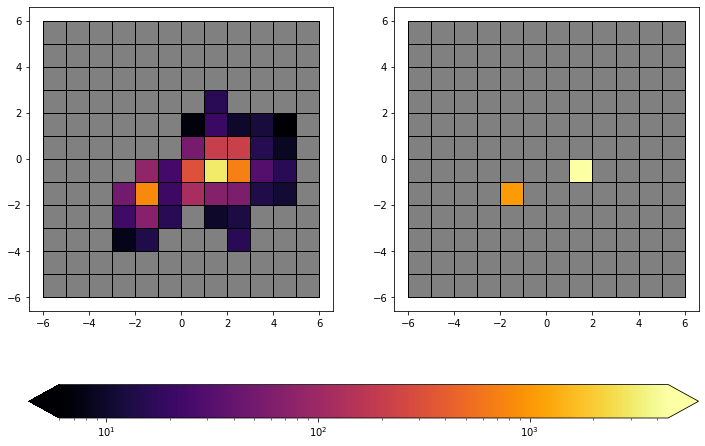

In [14]:
event_number = 7
true_event = np.exp(inputs[event_number]*11)
ml_event = np.exp(ml_events[event_number]*11)
ml_event[ml_event<2] = 0
true_event[true_event<5] = 0
display_event_comparison(true_event, ml_event)
print(f"max true {np.max(true_event)} max eval {np.max(ml_event)}")
print(f"sum true {np.sum(true_event)} sum eval {np.sum(ml_event)}")